In [86]:
import os, math
import pandas as pd

from os.path import join
import json
import boto3
import numpy as np
import pandas as pd

from rastervision.tagging.data.factory import TaggingDataGeneratorFactory
from rastervision.tagging.data.planet_kaggle import TagStore
from rastervision.tagging.options import TaggingOptions
from rastervision.common.settings import TRAIN, VALIDATION, TEST

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer

%matplotlib inline

In [2]:
s3_bucket = "raster-vision"
s3_prefix = "results/tagging"
working_dir = "/opt/data/datasets/planet_kaggle/ensemble_working_dir/"

In [120]:
def normal_named_ensemble(base_name, nb_cross_validation=5):
    d = {}
    models = []
    for i in range(0,nb_cross_validation):
        models.append(join(base_name,str(i)))
    d['cross_validation'] = models
    d['final_predict'] = join(base_name, "avg")
    return d

ensembles_names = {#"7_7_17/tif_ensemble_0" : normal_named_ensemble("7_7_17/tif_ensemble_0"),
                   "7_7_17/jpg_ensemble_0" : normal_named_ensemble("7_7_17/jpg_ensemble_0")}
print(json.dumps(ensembles_names, indent=2))

{
  "7_7_17/jpg_ensemble_0": {
    "cross_validation": [
      "7_7_17/jpg_ensemble_0/0",
      "7_7_17/jpg_ensemble_0/1",
      "7_7_17/jpg_ensemble_0/2",
      "7_7_17/jpg_ensemble_0/3",
      "7_7_17/jpg_ensemble_0/4"
    ],
    "final_predict": "7_7_17/jpg_ensemble_0/avg"
  }
}


In [4]:
def download_file(model, end_path, force=False):
    local_path = join(working_dir, model, end_path)
    if not os.path.exists(local_path):
        s3 = boto3.resource('s3')
        key = join(s3_prefix, model, end_path)
        if not os.path.isdir(join(working_dir, model)):
            os.makedirs(join(working_dir, model))

        s3.Bucket(s3_bucket).download_file(key, local_path)
    return local_path

def get_options(model_name):
    options_path = join(working_dir, model_name, "options.json")
    with open(options_path) as options_file:
        options_dict = json.load(options_file)
        options_dict['requires_channel_stats'] = False
        options = TaggingOptions(options_dict)
        return options


In [5]:
# Force download of test data
from rastervision.tagging.data.planet_kaggle import (PlanetKaggleTiffFileGenerator, PlanetKaggleJpgFileGenerator)
from rastervision.common.settings import datasets_path

g1 = PlanetKaggleTiffFileGenerator(datasets_path, get_options("7_5_17/ensemble/0"))
g2 = PlanetKaggleJpgFileGenerator(datasets_path, get_options("7_5_17/ensemble/0"))

/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [6]:
def get_model_results(model_name, raw_probs, split):
    download_file(model_name, "options.json")
    model_name = model_name
    options = get_options(model_name)      

    generator = TaggingDataGeneratorFactory().get_data_generator(options)
    tag_store = generator.tag_store
    file_inds = generator.get_file_inds(split)

    print("%s (%s) has %s files. Raw score shape is %s" % (model_name, split, len(file_inds), str(raw_probs.shape)))
    probs = []
    for file_i, file_ind in enumerate(file_inds):
        d = {}
        d['image_name'] = file_ind
        for tag_i, tag in enumerate(tag_store.active_tags):
            d[tag] = raw_probs[file_i][tag_i]
        probs.append(d)
    
    df = pd.DataFrame.from_dict(probs)

    return df

def get_test_model_results(model_name):
    raw_probs = np.load(download_file(model_name, "test_probs.npy"))
    split = TEST
        
    return get_model_results(model_name, raw_probs, split)
        
def get_train_model_results(model_name):
    raw_probs = np.load(download_file(model_name, "validation_probs.npy"))
    split = VALIDATION
        
    return get_model_results(model_name, raw_probs, split)

In [31]:
ensembles = {}

# Grab relevant files from ensembles
for k in ensembles_names:
    ensembles[k] = {}
    ensembles[k]['test_model'] = get_test_model_results(ensembles_names[k]['final_predict'])
    train_models = []
    for m in ensembles_names[k]['cross_validation']:
        train_models.append(get_train_model_results(m))
    ensembles[k]['train_model'] = train_models[0]
    for m in train_models[1:]:
        ensembles[k]['train_model'] = ensembles[k]['train_model'].append(m)

7_7_17/tif_ensemble_0/avg (test) has 61191 files. Raw score shape is (61191, 17)
7_7_17/tif_ensemble_0/0 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/tif_ensemble_0/1 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/tif_ensemble_0/2 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/tif_ensemble_0/3 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/tif_ensemble_0/4 (validation) has 8095 files. Raw score shape is (8095, 17)
7_7_17/jpg_ensemble_0/avg (test) has 61191 files. Raw score shape is (61191, 17)
7_7_17/jpg_ensemble_0/0 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/jpg_ensemble_0/1 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/jpg_ensemble_0/2 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/jpg_ensemble_0/3 (validation) has 8096 files. Raw score shape is (8096, 17)
7_7_17/jpg_ensemble_0/4 (validation) has 8095 files. Raw score shape is (8095, 17)


In [121]:
## Create dataframes with each model prediction and features
names = list(ensembles_names.keys())

def rename_columns(prefix, df):
    for c in list(df.columns):
        if c != 'image_name':
            df = df.rename(columns={c: "{}_{}".format(prefix, c)})
    return df


train_df = rename_columns(names[0], ensembles[names[0]]['train_model'])
test_df = rename_columns(names[0], ensembles[names[0]]['test_model'])

for n in names[1:]:
    train_df = pd.merge(train_df, 
                        rename_columns(n, ensembles[n]['train_model']),
                        on='image_name')
    test_df = pd.merge(test_df, 
                      rename_columns(n, ensembles[n]['test_model']),
                      on='image_name')
    
features_df = pd.read_csv("/opt/data/datasets/planet_kaggle/image_features_total.csv")

#train_df = pd.merge(train_df, 
#                    features_df,
#                    on='image_name')
#test_df = pd.merge(test_df, 
#                   features_df,
#                   on='image_name')
predict_df = test_df.copy()

In [34]:
# Given a sequence of data frames, write out a csv for training on each tag/multitag
atmos_tags = ["cloudy", "hazy", "clear", "partly_cloudy"]

print(train_df.count())
print(test_df.count())
61191+40479

7_7_17/tif_ensemble_0_agriculture          40479
7_7_17/tif_ensemble_0_artisinal_mine       40479
7_7_17/tif_ensemble_0_bare_ground          40479
7_7_17/tif_ensemble_0_blooming             40479
7_7_17/tif_ensemble_0_blow_down            40479
7_7_17/tif_ensemble_0_clear                40479
7_7_17/tif_ensemble_0_cloudy               40479
7_7_17/tif_ensemble_0_conventional_mine    40479
7_7_17/tif_ensemble_0_cultivation          40479
7_7_17/tif_ensemble_0_habitation           40479
7_7_17/tif_ensemble_0_haze                 40479
image_name                                 40479
7_7_17/tif_ensemble_0_partly_cloudy        40479
7_7_17/tif_ensemble_0_primary              40479
7_7_17/tif_ensemble_0_road                 40479
7_7_17/tif_ensemble_0_selective_logging    40479
7_7_17/tif_ensemble_0_slash_burn           40479
7_7_17/tif_ensemble_0_water                40479
dtype: int64
7_7_17/tif_ensemble_0_agriculture          61191
7_7_17/tif_ensemble_0_artisinal_mine       61191
7_7_17/

101670

In [122]:
# Get the labels for training
train_tags = pd.read_csv("/opt/data/datasets/planet_kaggle/train_v2.csv")
tag_store = TagStore()


In [123]:
training_labels = {}
for tag in tag_store.active_tags:
    c = train_tags.copy()
    def assign_binary_classification(row):
        if tag in row['tags'].split(' '):
            return 1
        else:
            return 0
    c = train_tags.copy().rename(columns={'tags': 'y'})
    c['y'] = train_tags.apply(assign_binary_classification, axis=1)
    training_labels[tag] = c

In [66]:
def modelfit(alg, dtrain, predictors, label_column, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[label_column].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[label_column],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    metrics.fbeta_score(beta=2)
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[label_column].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[label_column], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [67]:
for tag in tag_store.active_tags[:1]:
    tag_train_df = pd.merge(train_df,
                            training_labels[tag],
                            on="image_name")
    #Choose all predictors except target & IDcols
    label_column = 'y'
    predictors = [x for x in tag_train_df.columns if x not in [label_column, 'image_name']]
    xgb1 = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27)
    modelfit(xgb1, tag_train_df, predictors, label_column)
    

/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:210: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:210: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', Deprec


Model Report
Accuracy : 0.9193
AUC Score (Train): 0.976249


TypeError: 'str' object is not callable

In [124]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='samples')
predictors = [x for x in train_df.columns if x not in [label_column, 'image_name'] and not x.startswith('Unnamed')]
predictors

['7_7_17/jpg_ensemble_0_agriculture',
 '7_7_17/jpg_ensemble_0_artisinal_mine',
 '7_7_17/jpg_ensemble_0_bare_ground',
 '7_7_17/jpg_ensemble_0_blooming',
 '7_7_17/jpg_ensemble_0_blow_down',
 '7_7_17/jpg_ensemble_0_clear',
 '7_7_17/jpg_ensemble_0_cloudy',
 '7_7_17/jpg_ensemble_0_conventional_mine',
 '7_7_17/jpg_ensemble_0_cultivation',
 '7_7_17/jpg_ensemble_0_habitation',
 '7_7_17/jpg_ensemble_0_haze',
 '7_7_17/jpg_ensemble_0_partly_cloudy',
 '7_7_17/jpg_ensemble_0_primary',
 '7_7_17/jpg_ensemble_0_road',
 '7_7_17/jpg_ensemble_0_selective_logging',
 '7_7_17/jpg_ensemble_0_slash_burn',
 '7_7_17/jpg_ensemble_0_water']

In [131]:
tag = 'agriculture'

tag_train_df = pd.merge(train_df,
                        training_labels[tag],
                        on="image_name")

y_train = tag_train_df.pop('y')
final_train = tag_train_df[predictors]
final_test = test_df[predictors]

In [132]:
## Try 2

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = f2_scorer, cv = 5, n_jobs = -1) 
optimized_GBM.fit(final_train, y_train)

/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationW

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/conda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/opt/conda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fa832576b70, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fa832576b70, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/conda/lib/python3.5/site-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 9, 19, 21, 33, 336906, tzinfo=datetime.timezone.utc), 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'session': 'F6F560F38E6E4E03B37083A6BFAB433A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'F6F560F38E6E4E03B37083A6BFAB433A']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 9, 19, 21, 33, 336906, tzinfo=datetime.timezone.utc), 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'session': 'F6F560F38E6E4E03B37083A6BFAB433A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'F6F560F38E6E4E03B37083A6BFAB433A'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 9, 19, 21, 33, 336906, tzinfo=datetime.timezone.utc), 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'session': 'F6F560F38E6E4E03B37083A6BFAB433A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '5AE81FDB12F24069B6817A3ECF5CFAEA', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/opt/conda/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="## Try 2\n\ncv_params = {'max_depth': [3,5,7], 'mi...bs = -1) \noptimized_GBM.fit(final_train, y_train)", store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-132-3f87911993e0>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fa7e8e2b7f0, executi..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fa7e3da6c00, file "<ipython-input-132-3f87911993e0>", line 9>
        result = <ExecutionResult object at 7fa7e8e2b7f0, executi..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fa7e3da6c00, file "<ipython-input-132-3f87911993e0>", line 9>, result=<ExecutionResult object at 7fa7e8e2b7f0, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fa7e3da6c00, file "<ipython-input-132-3f87911993e0>", line 9>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'import os, math\nimport pandas as pd\n\nfrom os.pat...t matplotlib.gridspec as gridspec\n\nimport xgboost', 's3_bucket = "raster-vision"\ns3_prefix = "results...ata/datasets/planet_kaggle/ensemble_working_dir/"', 'def normal_named_ensemble(base_name, nb_cross_va...0")}\nprint(json.dumps(ensembles_names, indent=2))', 'def download_file(model, end_path, force=False):...ggingOptions(options_dict)\n        return options', '# Force download of test data\nfrom rastervision....(datasets_path, get_options("7_5_17/ensemble/0"))', 'def get_model_results(model_name, raw_probs, spl...n get_model_results(model_name, raw_probs, split)', "ensembles = {}\n\n# Grab relevant files from ensem...n_model'] = ensembles[k]['train_model'].append(m)", "g = ensembles['7_5_17/ensemble']['train_model']\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']['image_name'].unique()\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']['image_name'].unique()\nlen(g)", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']\ng.count()", "## Create dataframes with each model prediction\n...l']\n ensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...del']\n ensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...del']\n ensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...el']\nensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...el']\nensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...odel']\nensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...\nlist(ensembles[names[0]]['train_model'].columns)", ...], 'Out': {9: agriculture          40479
artisinal_mine       ...    40479
water                40479
dtype: int64, 11: 40479, 12: agriculture          40479
artisinal_mine       ...    40479
water                40479
dtype: int64, 18: Index(['agriculture', 'artisinal_mine', 'bare_gr...g', 'slash_burn', 'water'],
      dtype='object'), 19: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'image_name', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'], 25:       7_7_17/tif_ensemble_0_agriculture  7_7_17/...            0.000512  

[40479 rows x 18 columns], 26:       7_7_17/tif_ensemble_0_agriculture  7_7_17/...            0.000512  

[40479 rows x 18 columns], 29: 101670, 33:        7_7_17/tif_ensemble_0_agriculture  \
0   ... 
61190     0.090993  

[61191 rows x 92 columns], 34: 101670, ...}, 'PlanetKaggleJpgFileGenerator': <class 'rastervision.tagging.data.planet_kaggle.PlanetKaggleJpgFileGenerator'>, 'PlanetKaggleTiffFileGenerator': <class 'rastervision.tagging.data.planet_kaggle.PlanetKaggleTiffFileGenerator'>, 'TEST': 'test', 'TRAIN': 'train', 'TagStore': <class 'rastervision.tagging.data.planet_kaggle.TagStore'>, 'TaggingDataGeneratorFactory': <class 'rastervision.tagging.data.factory.TaggingDataGeneratorFactory'>, 'TaggingOptions': <class 'rastervision.tagging.options.TaggingOptions'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', 'import os, math\nimport pandas as pd\n\nfrom os.pat...t matplotlib.gridspec as gridspec\n\nimport xgboost', 's3_bucket = "raster-vision"\ns3_prefix = "results...ata/datasets/planet_kaggle/ensemble_working_dir/"', 'def normal_named_ensemble(base_name, nb_cross_va...0")}\nprint(json.dumps(ensembles_names, indent=2))', 'def download_file(model, end_path, force=False):...ggingOptions(options_dict)\n        return options', '# Force download of test data\nfrom rastervision....(datasets_path, get_options("7_5_17/ensemble/0"))', 'def get_model_results(model_name, raw_probs, spl...n get_model_results(model_name, raw_probs, split)', "ensembles = {}\n\n# Grab relevant files from ensem...n_model'] = ensembles[k]['train_model'].append(m)", "g = ensembles['7_5_17/ensemble']['train_model']\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']['image_name'].unique()\ng.count()", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']['image_name'].unique()\nlen(g)", "g = ensembles['7_7_17/jpg_ensemble_0']['train_model']\ng.count()", "## Create dataframes with each model prediction\n...l']\n ensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...del']\n ensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...del']\n ensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...el']\nensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...el']\nensembles[names[0]]['train_model'].columns()", "## Create dataframes with each model prediction\n...odel']\nensembles[names[0]]['train_model'].columns", "## Create dataframes with each model prediction\n...\nlist(ensembles[names[0]]['train_model'].columns)", ...], 'Out': {9: agriculture          40479
artisinal_mine       ...    40479
water                40479
dtype: int64, 11: 40479, 12: agriculture          40479
artisinal_mine       ...    40479
water                40479
dtype: int64, 18: Index(['agriculture', 'artisinal_mine', 'bare_gr...g', 'slash_burn', 'water'],
      dtype='object'), 19: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'image_name', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'], 25:       7_7_17/tif_ensemble_0_agriculture  7_7_17/...            0.000512  

[40479 rows x 18 columns], 26:       7_7_17/tif_ensemble_0_agriculture  7_7_17/...            0.000512  

[40479 rows x 18 columns], 29: 101670, 33:        7_7_17/tif_ensemble_0_agriculture  \
0   ... 
61190     0.090993  

[61191 rows x 92 columns], 34: 101670, ...}, 'PlanetKaggleJpgFileGenerator': <class 'rastervision.tagging.data.planet_kaggle.PlanetKaggleJpgFileGenerator'>, 'PlanetKaggleTiffFileGenerator': <class 'rastervision.tagging.data.planet_kaggle.PlanetKaggleTiffFileGenerator'>, 'TEST': 'test', 'TRAIN': 'train', 'TagStore': <class 'rastervision.tagging.data.planet_kaggle.TagStore'>, 'TaggingDataGeneratorFactory': <class 'rastervision.tagging.data.factory.TaggingDataGeneratorFactory'>, 'TaggingOptions': <class 'rastervision.tagging.options.TaggingOptions'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/opt/notebooks/planet_kaggle/<ipython-input-132-3f87911993e0> in <module>()
      4 ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
      5              'objective': 'binary:logistic'}
      6 optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
      7                             cv_params, 
      8                              scoring = f2_scorer, cv = 5, n_jobs = -1) 
----> 9 optimized_GBM.fit(final_train, y_train)
     10 
     11 
     12 
     13 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...core, beta=2, average=samples),
       verbose=0), X=       7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns], y=0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64)
    824         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    825             Target relative to X for classification or regression;
    826             None for unsupervised learning.
    827 
    828         """
--> 829         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...ore, beta=2, average=samples),
       verbose=0)>
        X =        7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns]
        y = 0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64
        self.param_grid = {'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]}
    830 
    831 
    832 class RandomizedSearchCV(BaseSearchCV):
    833     """Randomized search on hyper parameters.

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e...core, beta=2, average=samples),
       verbose=0), X=       7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns], y=0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64, parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    568         )(
    569             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    570                                     train, test, self.verbose, parameters,
    571                                     self.fit_params, return_parameters=True,
    572                                     error_score=self.error_score)
--> 573                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    574                 for train, test in cv)
    575 
    576         # Out is a list of triplet: score, estimator, n_test_samples
    577         n_fits = len(out)

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jul  9 19:21:59 2017
PID: 275                                Python 3.5.1: /opt/conda/bin/python
...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8),        7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns], 0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64, make_scorer(fbeta_score, beta=2, average=samples), array([ 8083,  8084,  8087, ..., 40476, 40477, 40478]), array([   0,    1,    2, ..., 8122, 8126, 8127]), 0, {'max_depth': 3, 'min_child_weight': 1}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8),        7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns], 0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64, make_scorer(fbeta_score, beta=2, average=samples), array([ 8083,  8084,  8087, ..., 40476, 40477, 40478]), array([   0,    1,    2, ..., 8122, 8126, 8127]), 0, {'max_depth': 3, 'min_child_weight': 1}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8), X=       7_7_17/jpg_ensemble_0_agriculture  \
0   ...        2.178669e-03  

[40479 rows x 17 columns], y=0        1
1        1
2        0
3        0
4   ...0
40478    0
Name: y, Length: 40479, dtype: int64, scorer=make_scorer(fbeta_score, beta=2, average=samples), train=array([ 8083,  8084,  8087, ..., 40476, 40477, 40478]), test=array([   0,    1,    2, ..., 8122, 8126, 8127]), verbose=0, parameters={'max_depth': 3, 'min_child_weight': 1}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1679                              " numeric value. (Hint: if using 'raise', please"
   1680                              " make sure that it has been spelled correctly.)"
   1681                              )
   1682 
   1683     else:
-> 1684         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8)
        X_test =       7_7_17/jpg_ensemble_0_agriculture  7_7_17/...             0.044459  

[8096 rows x 17 columns]
        y_test = 0       1
1       1
2       0
3       0
4       ...  1
8127    1
Name: y, Length: 8096, dtype: int64
        scorer = make_scorer(fbeta_score, beta=2, average=samples)
   1685         if return_train_score:
   1686             train_score = _score(estimator, X_train, y_train, scorer)
   1687 
   1688     scoring_time = time.time() - start_time

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py in _score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8), X_test=      7_7_17/jpg_ensemble_0_agriculture  7_7_17/...             0.044459  

[8096 rows x 17 columns], y_test=0       1
1       1
2       0
3       0
4       ...  1
8127    1
Name: y, Length: 8096, dtype: int64, scorer=make_scorer(fbeta_score, beta=2, average=samples))
   1736 def _score(estimator, X_test, y_test, scorer):
   1737     """Compute the score of an estimator on a given test set."""
   1738     if y_test is None:
   1739         score = scorer(estimator, X_test)
   1740     else:
-> 1741         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(fbeta_score, beta=2, average=samples)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8)
        X_test =       7_7_17/jpg_ensemble_0_agriculture  7_7_17/...             0.044459  

[8096 rows x 17 columns]
        y_test = 0       1
1       1
2       0
3       0
4       ...  1
8127    1
Name: y, Length: 8096, dtype: int64
   1742     if hasattr(score, 'item'):
   1743         try:
   1744             # e.g. unwrap memmapped scalars
   1745             score = score.item()

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(fbeta_score, beta=2, average=samples), estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...ght=1, seed=0, silent=True,
       subsample=0.8), X=      7_7_17/jpg_ensemble_0_agriculture  7_7_17/...             0.044459  

[8096 rows x 17 columns], y_true=0       1
1       1
2       0
3       0
4       ...  1
8127    1
Name: y, Length: 8096, dtype: int64, sample_weight=None)
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)
     96         else:
     97             return self._sign * self._score_func(y_true, y_pred,
---> 98                                                  **self._kwargs)
        self._kwargs = {'average': 'samples', 'beta': 2}
     99 
    100 
    101 class _ProbaScorer(_BaseScorer):
    102     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py in fbeta_score(y_true=0       1
1       1
2       0
3       0
4       ...  1
8127    1
Name: y, Length: 8096, dtype: int64, y_pred=array([1, 1, 0, ..., 1, 1, 1]), beta=2, labels=None, pos_label=1, average='samples', sample_weight=None)
    801                                                  beta=beta,
    802                                                  labels=labels,
    803                                                  pos_label=pos_label,
    804                                                  average=average,
    805                                                  warn_for=('f-score',),
--> 806                                                  sample_weight=sample_weight)
        sample_weight = None
    807     return f
    808 
    809 
    810 def _prf_divide(numerator, denominator, metric, modifier, average, warn_for):

...........................................................................
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py in precision_recall_fscore_support(y_true=array([1, 1, 0, ..., 1, 1, 1]), y_pred=array([1, 1, 0, ..., 1, 1, 1]), beta=2, labels=array([0, 1]), pos_label=1, average='samples', warn_for=('f-score',), sample_weight=None)
   1057                                  sample_weight=sample_weight)
   1058         true_sum = count_nonzero(y_true, axis=sum_axis,
   1059                                  sample_weight=sample_weight)
   1060 
   1061     elif average == 'samples':
-> 1062         raise ValueError("Sample-based precision, recall, fscore is "
   1063                          "not meaningful outside multilabel "
   1064                          "classification. See the accuracy_score instead.")
   1065     else:
   1066         le = LabelEncoder()

ValueError: Sample-based precision, recall, fscore is not meaningful outside multilabel classification. See the accuracy_score instead.
___________________________________________________________________________

In [73]:
optimized_GBM.grid_scores_

[mean: 0.90027, std: 0.00987, params: {'min_child_weight': 1, 'max_depth': 3},
 mean: 0.90481, std: 0.00290, params: {'min_child_weight': 3, 'max_depth': 3},
 mean: 0.90425, std: 0.00232, params: {'min_child_weight': 5, 'max_depth': 3},
 mean: 0.90444, std: 0.00174, params: {'min_child_weight': 1, 'max_depth': 5},
 mean: 0.90504, std: 0.00162, params: {'min_child_weight': 3, 'max_depth': 5},
 mean: 0.90378, std: 0.00195, params: {'min_child_weight': 5, 'max_depth': 5},
 mean: 0.90627, std: 0.00250, params: {'min_child_weight': 1, 'max_depth': 7},
 mean: 0.90514, std: 0.00226, params: {'min_child_weight': 3, 'max_depth': 7},
 mean: 0.90484, std: 0.00303, params: {'min_child_weight': 5, 'max_depth': 7}]

In [74]:
tag

'agriculture'

In [80]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = "f1", cv = 5, n_jobs = -1)
optimized_GBM.fit(final_train, y_train)

/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationW

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [81]:
optimized_GBM.grid_scores_

[mean: 0.84393, std: 0.00417, params: {'subsample': 0.7, 'learning_rate': 0.1},
 mean: 0.84587, std: 0.00317, params: {'subsample': 0.8, 'learning_rate': 0.1},
 mean: 0.84537, std: 0.00286, params: {'subsample': 0.9, 'learning_rate': 0.1},
 mean: 0.84970, std: 0.00276, params: {'subsample': 0.7, 'learning_rate': 0.01},
 mean: 0.85012, std: 0.00230, params: {'subsample': 0.8, 'learning_rate': 0.01},
 mean: 0.84968, std: 0.00420, params: {'subsample': 0.9, 'learning_rate': 0.01}]

In [82]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [83]:
our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [84]:
cv_xgb

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.099543,0.003276,0.082341,0.001031
1,0.095763,0.003102,0.078493,0.000370
2,0.093663,0.001831,0.076578,0.000781
3,0.094527,0.002337,0.075701,0.000591
4,0.093119,0.001078,0.075102,0.000747
5,0.093984,0.001890,0.075015,0.000684
6,0.093762,0.001958,0.074076,0.000872
7,0.092946,0.002053,0.074324,0.001145
8,0.092502,0.001636,0.073891,0.001002
9,0.092650,0.001830,0.073508,0.000729


In [85]:
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 311)

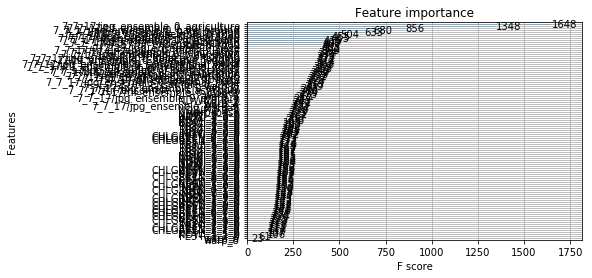

In [87]:
xgb.plot_importance(final_gb)

In [88]:
importances = final_gb.get_fscore()
importances

{'7_7_17/jpg_ensemble_0_agriculture': 1648,
 '7_7_17/jpg_ensemble_0_artisinal_mine': 320,
 '7_7_17/jpg_ensemble_0_bare_ground': 856,
 '7_7_17/jpg_ensemble_0_blooming': 415,
 '7_7_17/jpg_ensemble_0_blow_down': 384,
 '7_7_17/jpg_ensemble_0_clear': 239,
 '7_7_17/jpg_ensemble_0_cloudy': 309,
 '7_7_17/jpg_ensemble_0_conventional_mine': 369,
 '7_7_17/jpg_ensemble_0_cultivation': 680,
 '7_7_17/jpg_ensemble_0_habitation': 504,
 '7_7_17/jpg_ensemble_0_haze': 405,
 '7_7_17/jpg_ensemble_0_partly_cloudy': 358,
 '7_7_17/jpg_ensemble_0_primary': 261,
 '7_7_17/jpg_ensemble_0_road': 633,
 '7_7_17/jpg_ensemble_0_selective_logging': 376,
 '7_7_17/jpg_ensemble_0_slash_burn': 453,
 '7_7_17/jpg_ensemble_0_water': 371,
 '7_7_17/tif_ensemble_0_agriculture': 1348,
 '7_7_17/tif_ensemble_0_artisinal_mine': 349,
 '7_7_17/tif_ensemble_0_bare_ground': 455,
 '7_7_17/tif_ensemble_0_blooming': 377,
 '7_7_17/tif_ensemble_0_blow_down': 338,
 '7_7_17/tif_ensemble_0_clear': 314,
 '7_7_17/tif_ensemble_0_cloudy': 280,
 '7_

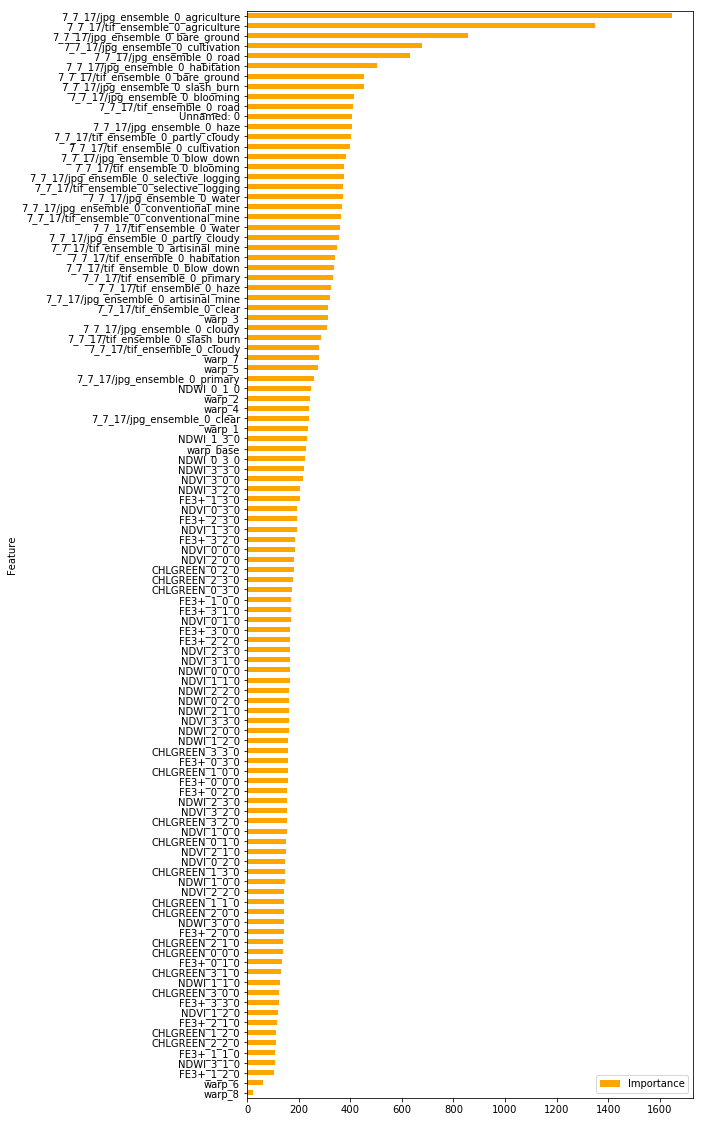

In [91]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,20), color = 'orange')


In [96]:
testdmat = xgb.DMatrix(final_test)

In [100]:
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  1.,  0., ...,  1.,  0.,  0.], dtype=float32)

In [101]:
predict_df[tag] = y_pred

In [126]:
#predict_df
test_df

,7_7_17/jpg_ensemble_0_agriculture,7_7_17/jpg_ensemble_0_artisinal_mine,7_7_17/jpg_ensemble_0_bare_ground,7_7_17/jpg_ensemble_0_blooming,7_7_17/jpg_ensemble_0_blow_down,7_7_17/jpg_ensemble_0_clear,7_7_17/jpg_ensemble_0_cloudy,7_7_17/jpg_ensemble_0_conventional_mine,7_7_17/jpg_ensemble_0_cultivation,7_7_17/jpg_ensemble_0_habitation,7_7_17/jpg_ensemble_0_haze,image_name,7_7_17/jpg_ensemble_0_partly_cloudy,7_7_17/jpg_ensemble_0_primary,7_7_17/jpg_ensemble_0_road,7_7_17/jpg_ensemble_0_selective_logging,7_7_17/jpg_ensemble_0_slash_burn,7_7_17/jpg_ensemble_0_water
0,0.006593,1.227814e-06,0.000095,0.155808,0.000539,0.999718,1.201286e-06,4.294196e-07,0.003322,0.000307,0.000058,file_0,0.000110,0.999985,0.001573,0.013501,1.803018e-05,0.002297
1,0.965643,9.352045e-04,0.134142,0.000909,0.002587,0.102517,7.797843e-05,1.160025e-04,0.266442,0.399149,0.000878,file_1,0.831766,0.995002,0.169385,0.000678,5.019158e-03,0.022818
2,0.319770,1.518424e-05,0.001028,0.000186,0.000026,0.088279,4.034244e-03,1.565119e-04,0.058544,0.011395,0.827790,file_10,0.014252,0.991927,0.993388,0.000508,4.394263e-05,0.765092
3,0.105552,3.709337e-04,0.005176,0.001538,0.000492,0.994960,1.973378e-06,1.261617e-04,0.036817,0.006867,0.007681,file_100,0.000436,0.999919,0.147508,0.002033,2.057974e-03,0.976798
4,0.501049,3.188605e-05,0.001234,0.007779,0.007485,0.998059,1.560016e-05,2.736878e-05,0.078868,0.001755,0.000188,file_1000,0.003033,0.999630,0.006978,0.007727,6.885097e-04,0.010482
5,0.009960,3.097987e-07,0.000032,0.002598,0.002089,0.999881,2.070727e-07,1.992447e-08,0.002742,0.000382,0.000015,file_10000,0.000073,0.999995,0.000356,0.000820,9.430286e-06,0.000269
6,0.908156,3.140897e-03,0.054457,0.000330,0.000186,0.853795,9.342238e-05,1.869427e-03,0.116770,0.030996,0.116041,file_10001,0.004246,0.958179,0.268585,0.000271,1.691507e-03,0.964635
7,0.932730,7.358319e-05,0.019670,0.001313,0.000213,0.964378,1.345066e-04,2.506581e-04,0.063546,0.334568,0.018636,file_10002,0.008050,0.883795,0.912517,0.002613,7.373900e-03,0.090385
8,0.982981,1.183421e-04,0.007842,0.001522,0.000277,0.916191,8.683297e-06,7.328387e-05,0.111503,0.003218,0.066440,file_10003,0.010209,0.999915,0.029716,0.000323,3.846149e-04,0.246145
9,0.007138,4.062941e-06,0.000107,0.000073,0.000227,0.001062,1.009135e-04,1.023243e-05,0.001218,0.000246,0.006083,file_10004,0.998579,0.999818,0.002948,0.000075,4.048973e-05,0.008957


In [127]:
xgboost_params = {'eta': 0.01, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':1} 

final_test = test_df[predictors]

for i, tag in enumerate(tag_store.active_tags):
    print("Training/Predicting tag {} ({} of {})".format(tag, i+1, len(tag_store.active_tags)))
    tag_train_df = pd.merge(train_df,
                            training_labels[tag],
                            on="image_name")
    y_train = tag_train_df.pop('y')
    final_train = tag_train_df[predictors]
    
    xgdmat = xgb.DMatrix(final_train, y_train) 
    final_gb = xgb.train(xgboost_params, xgdmat, num_boost_round = 311)
    testdmat = xgb.DMatrix(final_test)
    y_pred = final_gb.predict(testdmat) # Predict using our testdmat
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    predict_df[tag] = y_pred
print("Done.")

Training/Predicting tag agriculture (1 of 17)
Training/Predicting tag artisinal_mine (2 of 17)
Training/Predicting tag bare_ground (3 of 17)
Training/Predicting tag blooming (4 of 17)
Training/Predicting tag blow_down (5 of 17)
Training/Predicting tag clear (6 of 17)
Training/Predicting tag cloudy (7 of 17)
Training/Predicting tag conventional_mine (8 of 17)
Training/Predicting tag cultivation (9 of 17)
Training/Predicting tag habitation (10 of 17)
Training/Predicting tag haze (11 of 17)
Training/Predicting tag partly_cloudy (12 of 17)
Training/Predicting tag primary (13 of 17)
Training/Predicting tag road (14 of 17)
Training/Predicting tag selective_logging (15 of 17)
Training/Predicting tag slash_burn (16 of 17)
Training/Predicting tag water (17 of 17)
Done.


In [128]:
def mapper(row):
    tags = []
    for tag in tag_store.active_tags:
        if row[tag] == 1:
            tags.append(tag)
    return ' '.join(sorted(tags))

predict_df['tags'] = predict_df.apply(mapper, axis=1)


In [129]:
predict_df.to_csv("/opt/data/datasets/planet_kaggle/test_preds/stacking_ensemble-onlyjpg.csv", 
          columns=['image_name', 'tags'], index=False, header=True)

In [130]:
predict_df

,7_7_17/jpg_ensemble_0_agriculture,7_7_17/jpg_ensemble_0_artisinal_mine,7_7_17/jpg_ensemble_0_bare_ground,7_7_17/jpg_ensemble_0_blooming,7_7_17/jpg_ensemble_0_blow_down,7_7_17/jpg_ensemble_0_clear,7_7_17/jpg_ensemble_0_cloudy,7_7_17/jpg_ensemble_0_conventional_mine,7_7_17/jpg_ensemble_0_cultivation,7_7_17/jpg_ensemble_0_habitation,...,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water,tags
0,0.006593,1.227814e-06,0.000095,0.155808,0.000539,0.999718,1.201286e-06,4.294196e-07,0.003322,0.000307,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,clear primary
1,0.965643,9.352045e-04,0.134142,0.000909,0.002587,0.102517,7.797843e-05,1.160025e-04,0.266442,0.399149,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,agriculture partly_cloudy primary
2,0.319770,1.518424e-05,0.001028,0.000186,0.000026,0.088279,4.034244e-03,1.565119e-04,0.058544,0.011395,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,haze primary road
3,0.105552,3.709337e-04,0.005176,0.001538,0.000492,0.994960,1.973378e-06,1.261617e-04,0.036817,0.006867,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,clear primary water
4,0.501049,3.188605e-05,0.001234,0.007779,0.007485,0.998059,1.560016e-05,2.736878e-05,0.078868,0.001755,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,clear primary
5,0.009960,3.097987e-07,0.000032,0.002598,0.002089,0.999881,2.070727e-07,1.992447e-08,0.002742,0.000382,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,clear primary
6,0.908156,3.140897e-03,0.054457,0.000330,0.000186,0.853795,9.342238e-05,1.869427e-03,0.116770,0.030996,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,agriculture clear primary water
7,0.932730,7.358319e-05,0.019670,0.001313,0.000213,0.964378,1.345066e-04,2.506581e-04,0.063546,0.334568,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,agriculture clear primary road
8,0.982981,1.183421e-04,0.007842,0.001522,0.000277,0.916191,8.683297e-06,7.328387e-05,0.111503,0.003218,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,agriculture clear primary
9,0.007138,4.062941e-06,0.000107,0.000073,0.000227,0.001062,1.009135e-04,1.023243e-05,0.001218,0.000246,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,partly_cloudy primary
